In [ ]:
# Optional: uncomment to install packages if needed
# !pip install yfinance --quiet

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Parameters
SYMBOL = "^NSEI"   # NIFTY 50
START = "2015-11-28"
END = "2025-11-28"
OUTPUT_CSV = "nifty_10yr_clean_signals.csv"
TRADE_LOG_CSV = "nifty_trade_log.csv"

plt.rcParams['figure.figsize'] = (12,6)
print('Ready. Run the next cell to download data.')

Ready. Run the next cell to download data.


In [3]:
print(f"Downloading {SYMBOL} from {START} to {END}...")

df = yf.download(SYMBOL, start=START, end=END, progress=False)
print('Download complete. Raw columns:')
print(df.columns)


C:\Users\vamsh\AppData\Local\Temp\ipykernel_19296\99144050.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL, start=START, end=END, progress=False)


Download complete. Raw columns:
MultiIndex([( 'Close', '^NSEI'),
            (  'High', '^NSEI'),
            (   'Low', '^NSEI'),
            (  'Open', '^NSEI'),
            ('Volume', '^NSEI')],
           names=['Price', 'Ticker'])


In [4]:
# Normalize MultiIndex columns and prepare df
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

if 'Date' not in df.columns:
    df = df.reset_index()

# Keep standard columns and prefer 'Close'
expected = ['Date','Open','High','Low','Close','Adj Close','Volume']
use_close = 'Close' if 'Close' in df.columns else ('Adj Close' if 'Adj Close' in df.columns else None)
if use_close is None:
    raise KeyError('No Close/Adj Close column found. Columns: ' + str(df.columns.tolist()))

cols_to_keep = ['Date','Open','High','Low',use_close,'Volume']
cols_to_keep = [c for c in cols_to_keep if c in df.columns]

df = df[cols_to_keep].copy()
if use_close != 'Close':
    df.rename(columns={use_close:'Close'}, inplace=True)

# Ensure Date is a column and sorted
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print('Prepared sample:')
print(df.head(3))
print('Columns:', df.columns.tolist())

Prepared sample:
Price       Date         Open         High          Low        Close  Volume
0     2015-11-30  7936.250000  7966.000000  7922.799805  7935.250000  216300
1     2015-12-01  7958.149902  7972.149902  7934.149902  7954.899902  138600
2     2015-12-02  7976.700195  7979.299805  7910.799805  7931.350098  126300
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [5]:
# Feature engineering

df['Daily_Return'] = df['Close'].pct_change().fillna(0)

df['SMA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['SMA50'] = df['Close'].rolling(window=50, min_periods=1).mean()

# Conservative SMA crossover signal (act next day)
df['Signal_raw'] = (df['SMA20'] > df['SMA50']).astype(int)
df['Signal'] = df['Signal_raw'].shift(1).fillna(0).astype(int)

print(df[['Date','Close','SMA20','SMA50','Signal']].head(10))

Price       Date        Close        SMA20        SMA50  Signal
0     2015-11-30  7935.250000  7935.250000  7935.250000       0
1     2015-12-01  7954.899902  7945.074951  7945.074951       0
2     2015-12-02  7931.350098  7940.500000  7940.500000       0
3     2015-12-03  7864.149902  7921.412476  7921.412476       0
4     2015-12-04  7781.899902  7893.509961  7893.509961       0
5     2015-12-07  7765.399902  7872.158285  7872.158285       0
6     2015-12-08  7701.700195  7847.807129  7847.807129       0
7     2015-12-09  7612.500000  7818.393738  7818.393738       0
8     2015-12-10  7683.299805  7803.383301  7803.383301       0
9     2015-12-11  7610.450195  7784.089990  7784.089990       0


In [6]:
# Strategy returns

df['Strategy_Return'] = df['Daily_Return'] * df['Signal']

df['Cumulative_Market'] = (1 + df['Daily_Return']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()

# Metrics
def annualized_return_from_cum(cum_series, start_date, end_date):
    total_return = cum_series.iloc[-1] - 1
    days = (end_date - start_date).days
    years = days / 365.25
    if years <= 0:
        return np.nan
    return (1 + total_return) ** (1/years) - 1


def sharpe_ratio(returns, risk_free_rate=0.04, days_per_year=252):
    rf_daily = (1 + risk_free_rate) ** (1/days_per_year) - 1
    excess = returns - rf_daily
    mean_excess = excess.mean() * days_per_year
    std_excess = excess.std() * np.sqrt(days_per_year)
    if std_excess == 0:
        return np.nan
    return mean_excess / std_excess

start_date = df['Date'].iloc[0]
end_date = df['Date'].iloc[-1]

ann_ret_market = annualized_return_from_cum(df['Cumulative_Market'], start_date, end_date)
ann_ret_strategy = annualized_return_from_cum(df['Cumulative_Strategy'], start_date, end_date)
sharpe_market = sharpe_ratio(df['Daily_Return'])
sharpe_strategy = sharpe_ratio(df['Strategy_Return'])

print(f"Annualized Return (Market): {ann_ret_market:.2%}")
print(f"Annualized Return (Strategy): {ann_ret_strategy:.2%}")
print(f"Sharpe Ratio (Market): {sharpe_market:.2f}")
print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")

Annualized Return (Market): 12.70%
Annualized Return (Strategy): 13.97%
Sharpe Ratio (Market): 0.59
Sharpe Ratio (Strategy): 0.92


In [7]:
# Trade log generation
trades = []
position = 0
entry_date = None
entry_price = None

for i, row in df.iterrows():
    if position == 0 and row['Signal'] == 1:
        position = 1
        entry_date = row['Date']
        entry_price = row['Close']
    elif position == 1 and row['Signal'] == 0:
        exit_date = row['Date']
        exit_price = row['Close']
        ret = (exit_price / entry_price) - 1
        trades.append({'Entry_Date': entry_date,
                       'Entry_Price': entry_price,
                       'Exit_Date': exit_date,
                       'Exit_Price': exit_price,
                       'Return': ret})
        position = 0

trades_df = pd.DataFrame(trades)
trades_df.to_csv(TRADE_LOG_CSV, index=False)
print(f"Saved trade log: {TRADE_LOG_CSV} ({len(trades_df)} trades)")
trades_df.head()

Saved trade log: nifty_trade_log.csv (20 trades)


,Entry_Date,Entry_Price,Exit_Date,Exit_Price,Return
0,2016-03-22,7714.899902,2016-10-20,8699.400391,0.127610
1,2017-01-17,8398.000000,2017-09-11,10006.049805,0.191480
2,2017-09-13,10079.299805,2017-12-22,10493.000000,0.041045
3,2018-01-02,10442.200195,2018-02-28,10492.849609,0.004850
4,2018-04-25,10570.549805,2018-10-01,11008.299805,0.041412


In [8]:
# Save cleaned dataset for Power BI

df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned dataset: {OUTPUT_CSV}")

Saved cleaned dataset: nifty_10yr_clean_signals.csv


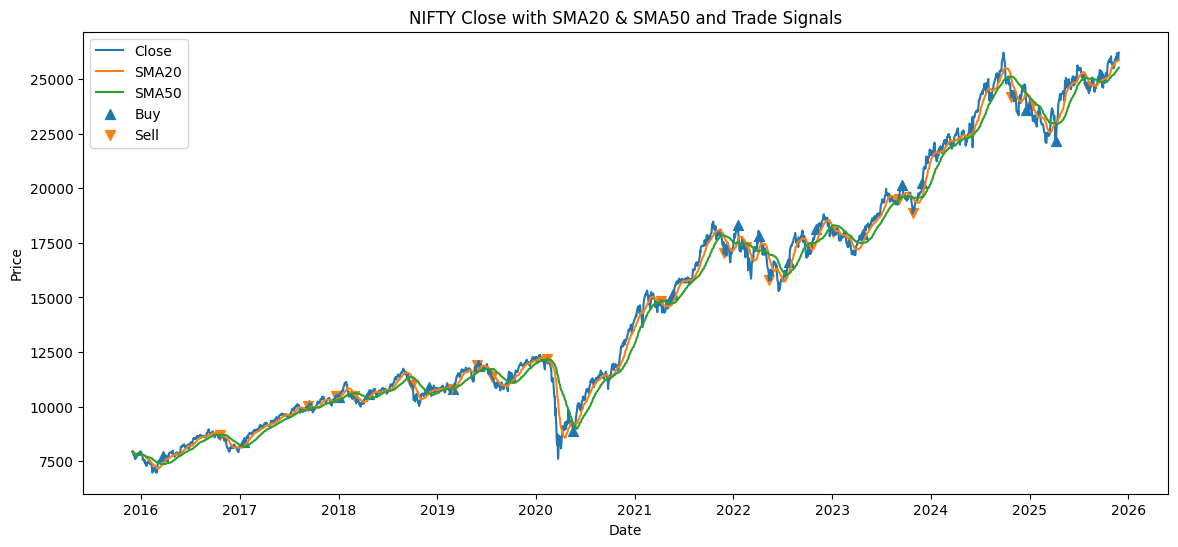

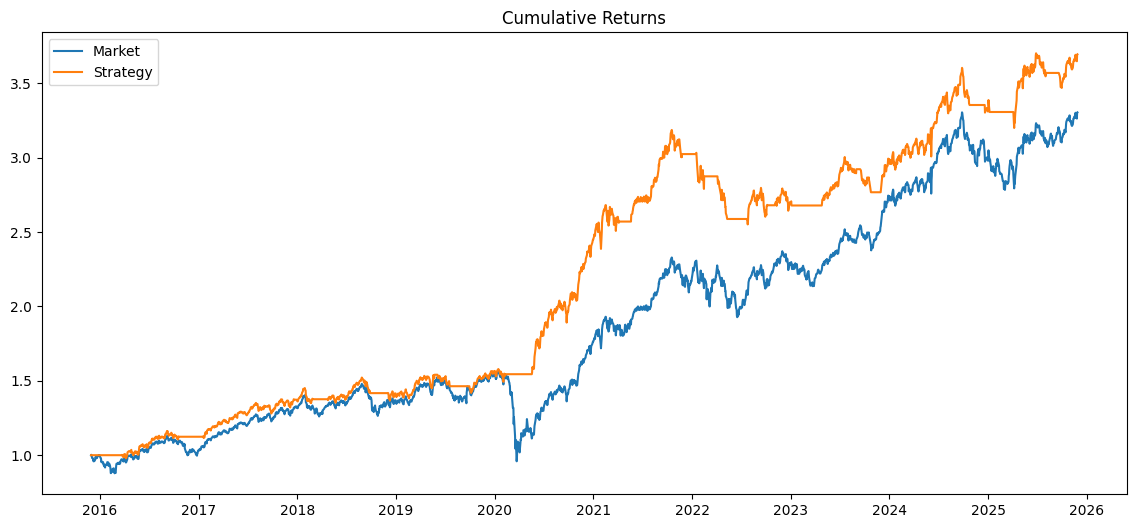

In [9]:
# Plots
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['SMA20'], label='SMA20')
plt.plot(df['Date'], df['SMA50'], label='SMA50')

buys = df[(df['Signal'] == 1) & (df['Signal'].shift(1) == 0)]
sells = df[(df['Signal'] == 0) & (df['Signal'].shift(1) == 1)]
if not buys.empty:
    plt.scatter(buys['Date'], buys['Close'], marker='^', s=50, label='Buy')
if not sells.empty:
    plt.scatter(sells['Date'], sells['Close'], marker='v', s=50, label='Sell')
plt.legend()
plt.title('NIFTY Close with SMA20 & SMA50 and Trade Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Cumulative_Market'], label='Market')
plt.plot(df['Date'], df['Cumulative_Strategy'], label='Strategy')
plt.legend()
plt.title('Cumulative Returns')
plt.show()